## Домашнее задание №1: Полносвязные нейронные сети

### Пожалуйста, заполните имя

In [0]:
STUDENT_NAME = 'Ruslan Sungatullin'

In [0]:
# Включает режим проверки
from importlib import reload

try:
    import test_lib
    TEST_MODE = True
except:
    TEST_MODE = False

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

**Не удаляйте клетки из этого jupyter-notebok! Это затруднит проверку!**

В этом задании вам предстоит самостоятельно самостоятельно реализовать простую полносвязную нейронную сеть, процедуру обучения. Правильность нашей реализации мы проверим на примере задачи распознавания рукописных цифр (датасет MNIST).

Каждый тип слоя мы будем реализовывать при помощи класса, который будет поддерживать три функции:
1. forward(X) - применяет функцию, реализуемую слоем, к входной матрице (X), X.shape = N x features_size, N - размер батча
2. backward(dLdy) - которая по $\frac{\partial L}{\partial y}$ будет вычислять $\frac{\partial L}{\partial x}$ и обновлять внутри себя $\frac{\partial L}{\partial w}$, dLdy.shape - N x 1 = градиент по каждому из объектов батча
3. step(learning_rate), которая будет обновлять веса в слое

Чтобы не применять функцию к каждому объекту в отдельности, мы будем подавать на вход слою матрицу размера (N, d), где N — количество объектов (размер batch-а), а d (то же, что и input_size, features_count) — размерность каждого объекта.

### Задание 1
**Требуется реализовать слои (в layers.py):**  
1. Linear. В инициализацию весов следует сделать из N(0, 0.01)
2. Sigmoid, ReLU, ELU, Tanh - нелинейности
3. SoftMax_NLLLoss. Обратите внимание, что это особый слой - он совмещает в себе и слой-предиктор, и функцию ошибок. Это нужно, чтобы упросить расчет градиента с помощью трюка log-sum-exp (позволяет избежать численных неустойчивостей):  
https://ljvmiranda921.github.io/notebook/2017/08/13/softmax-and-the-negative-log-likelihood/
4. MSE_Error - loss-функция, считает dL/dy для запуска backprop.
5. NeuralNetwork - класс, объединяющий слои

**Обратите внимание**
1. Изменять интерфейс классов в layers.py **не следует**, т.к. иначе тестирующий код не сможет выполниться
2. Важным требованием к реализации является векторизация всех слоев: **все операции должны быть сведены к матричным**, не должно быть циклов. Это значительно уменьшает временные затраты.
3. Отличная визуализация работы полносвязных нейронных сетей: http://playground.tensorflow.org/

### Проверка задания 1
Нужно написать свой код для проверки и пройти тесты кода, который не предоставляется

In [4]:
import layers
import imp
imp.reload(layers)

<module 'layers' from '/content/layers.py'>

**Проверка 1 - численный градиент**

1. Релизуйте функцию проверки численного градиента. Для этого для каждой переменной, по которой считается градиент, надо вычислить численный градиент: $f'(x) \approx \frac{f(x+\epsilon)-f(x-\epsilon)}{2\epsilon}$. Функция должна возвращать максимальное абсолютное отклонение аналитического градиента от численного. В качестве $\epsilon$ рекомендуется взять $10^{-6}$. При правильной реализации максимальное отличие будет иметь порядок $10^{-8}-10^{-6}$.

2. Протестируйте линейный слой при помощи реализованной функции check_gradient: $\frac{\partial L}{\partial x}$ и $\frac{\partial L}{\partial w}$.

3. По аналогии, протестируйте SoftMax_NLLLoss

In [5]:
# 1.
def check_gradient(func, X, gradient):
    '''
    Computes numerical gradient and compares it with analytcal.
    func: callable, function of which gradient we are interested. Example call: func(X)
    X: np.array of size (n x m)
    gradient: np.array of size (n x m)
    Returns: maximum absolute diviation between numerical gradient and analytical.
    '''
    epsilon=1e-6
    result = 0
    for i in range(X.shape[0]):
        for j in range(X.shape[1]):
            X1 = np.copy(X)
            X1[i][j] += epsilon
            X2 = np.copy(X)
            X2[i][j] -= epsilon
            num_gradient = (func(X1)-func(X2))*0.5/epsilon
            diff  = num_gradient - gradient[i][j]
            if (result < diff):
                result = diff
    return result

# 2. Проверка слоя Linear
lin = layers.Linear(10, 2)
X = np.ones((5, 10))
y = lin.forward(X)

func = lambda x: lin.forward(x).sum() # Аналог функции ошибок
dLdy = np.ones((5, 2)) # Очевидно, что производная суммы по всем y = 1
gradient = lin.backward(dLdy)
print("Check grad linear: {}".format(check_gradient(func, X, gradient)))

#3. Проверка SoftMax_NLLLoss
smax = layers.SoftMax_NLLLoss()
X = np.array([[5,4,2],[4,2,8],[4,4,1]])
smax_X = np.array([[0.71, 0.26, 0.04],[0.02, 0.00, 0.98],[0.49, 0.49, 0.02]])
print(np.round(smax.forward(X),2) == smax_X)

Check grad linear: 2.2499044727980477e-11
[[ True  True  True]
 [ True  True  True]
 [ True  True  True]]


In [0]:
# Проверка вашей реализации check_gradient и Linear
# Не изменяйте эти ячейки!
if TEST_MODE:
    try:
        test_lib.test_grad_checker(test_lib.check_gradient)
        test_lib.check_grads(layers.Linear, layers.Sigmoid, layers.SoftMax_NLLLoss, layers.Tanh)
    except Exception as e:
        print("!!>> Tasks grad_check failed:")
        raise e

**Проверка 2**  
Следующий код должен выполниться и дать корректную классификацию объектов. Это нужно, чтобы проверить интерфейс классов из layers

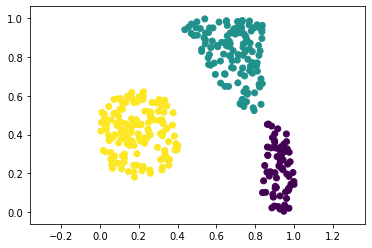

In [7]:
data = np.load('data.npz')
X, y = data['arr_0'], data['arr_1']
plt.scatter(X[:, 0], X[:, 1], c=y)
plt.axis('equal')
plt.show()

In [0]:
arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 3), layers.SoftMax_NLLLoss()]
network = layers.NeuralNetwork(arc)

def learn_network(network, X, y, learning_rate=0.1, iterations=16000):
    history = []
    for i in range(iterations):
        prediction = network.forward(X)
        history.append(network.get_loss(y))
        network.backward(y)
        network.step(learning_rate)
    return history
        
h =learn_network(network, X, y)

In [0]:
def plot_mesh_with_scatter(X, y, pred_func, N=50, additional=0.15):
    '''
    pred_func(mesh) - returns classes from mesh grid
    '''
    delta_x = (np.max(X[:, 0])-np.min(X[:, 0]))*additional
    delta_y = (np.max(X[:, 1])-np.min(X[:, 1]))*additional
    
    x_grid = np.linspace(np.min(X[:, 0])-delta_x, np.max(X[:, 0])+delta_x, N)
    y_grid = np.linspace(np.min(X[:, 1])-delta_y, np.max(X[:, 1])+delta_y, N)
    X_mesh, Y_mesh = np.meshgrid(x_grid, y_grid)
    mesh = np.dstack((X_mesh, Y_mesh)).reshape(N*N, 2)
    predictions = pred_func(mesh)
    plt.scatter(mesh[:, 0], mesh[:, 1], c=predictions, alpha=0.2)
    plt.scatter(X[:, 0], X[:, 1], c=y)
    plt.axis('equal')
    plt.show()

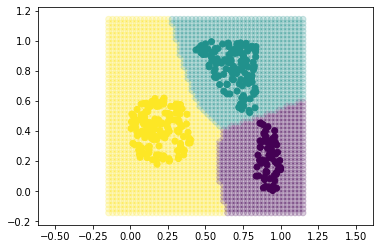

In [10]:
plot_mesh_with_scatter(X, y, lambda x: np.argmax(network.forward(x), 1))

### Задание 2
1. Попробуйте разные темпы обучения (6-7 значений в пределах 0.01 - 20, с логарифмическим масштабом).  
Как меняется сходимость и почему? Нарисуйте график оптимального значения функции потерь для различных значений learning_rate (для этого реализуйте в нейронной сети и ее слоях функцию get_loss)
2. Решите поставленную выше задачу как задачу регрессии с MSE. Изменилась ли разделяющая поверхность? Нарисуйте ее, с помощью plot_mesh_with_scatter.

**На это задание нет специальных тестов, оно проверяется вручную**

learning rate = 0.01


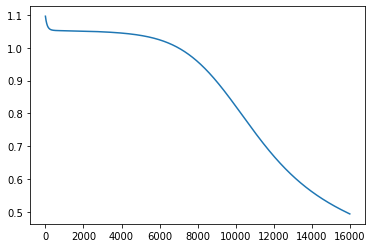

learning rate = 4.008


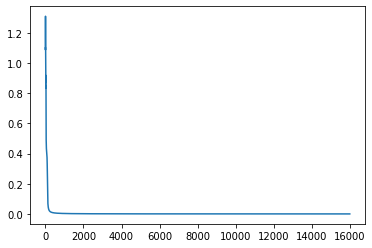

learning rate = 8.006


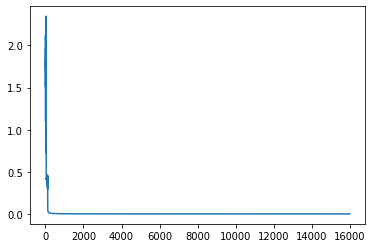

learning rate = 12.004


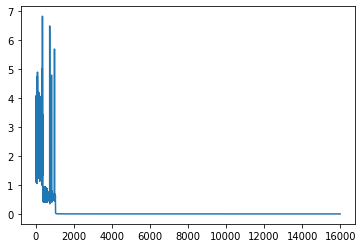

learning rate = 16.002


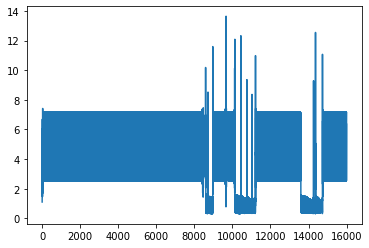

learning rate = 20.0


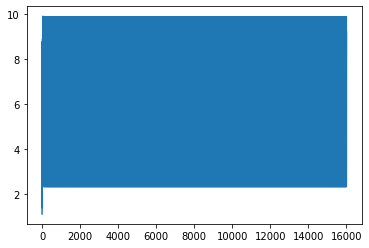

In [11]:
ll = np.linspace(0.01, 20, 6)
for l in ll:
    arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 3), layers.SoftMax_NLLLoss()]
    network = layers.NeuralNetwork(arc)
    history = learn_network(network, X, y, learning_rate=l)
    print("learning rate = {0}".format(l))
    plt.figure()
    plt.plot(history)
    plt.show()

При маленьком lerninng_rate и малом числе эпох алгоритм не успевает сойтись. При больших learning_rate сходимости вообще нет для 16000  эпох.

In [0]:
arc = [layers.Linear(2, 3), layers.Sigmoid(), layers.Linear(3, 1), layers.MSE_Error()]
network = layers.NeuralNetwork(arc)
h = learn_network(network, X, y)

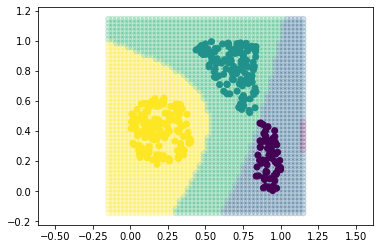

In [13]:
plot_mesh_with_scatter(X, y.flatten(), lambda x: np.around(network.forward(x).flatten()))

### Распознование рукописных цифр
Ниже приведен код для загрузки датасета и визуализация нескольких объектов из него

In [0]:
from torch.utils.data import DataLoader
from torchvision.datasets import MNIST
from torchvision import transforms
import torch
%matplotlib inline

In [15]:
# Не изменяйте имена в этой ячейке! Они нужны для тестов
transform = transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)) # Нормализация данных
                    ])
train_dataset = MNIST('.', train=True, download=True, transform=transform)
test_dataset = MNIST('.', train=False, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

9920512it [00:00, 28113142.12it/s]                            


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw


32768it [00:00, 453571.45it/s]
  1%|          | 16384/1648877 [00:00<00:11, 146769.38it/s]

Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw


1654784it [00:00, 7708991.50it/s]                            
8192it [00:00, 182176.37it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw
Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw
Processing...
Done!


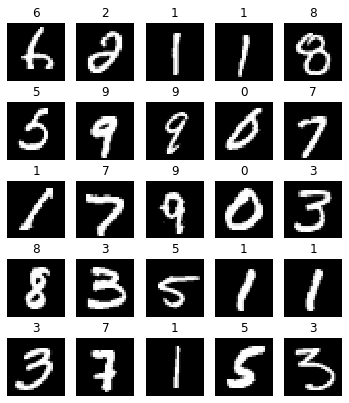

In [16]:
for X, y in train_loader:
    X = X.view(X.shape[0], -1)
    X = X.numpy() ### Converts torch.Tensor to numpy array
    y = y.numpy()

plt.figure(figsize=(6, 7))
for i in range(25):
    plt.subplot(5, 5, i+1)
    plt.imshow(X[i].reshape(28, 28), cmap=plt.cm.Greys_r)
    plt.title(y[i])
    plt.axis('off')

### Задание 3
Обучите полносвязную нейронную сеть с архитектурой 784-100-100-10 и сигмоидой в качестве нелинейности (объект создан ниже).  
Какую точность классификации удалось получить? Нарисуйте график сходимости на обучающей и тестовой выборках. В качестве темпа обучения (learning rate) возьмите 0.4. Число эпох выберете по своему усмотрению.

**Обратите внимание**  
1. Итерироваться по данным можно с помощью выражения *for X, y in some_loader* При этом X, y - будут иметь тип torch.Tensor. Чтобы конвертировать их в numpy-массивы нужно вызвать функцию .numpy()
2. Каждый объект из X имеет размерность 1x28x28. Поэтому перед .numpy() нужно вызвать *X = X.view(X.shape[0], -1)*, чтобы получить одномерный массив
3. Качество на тесте (масксимальное среди эпох) должно быть не хуже **0.972**

In [0]:
learning_rate = 0.4

In [0]:
def train_nn(network, epochs, learning_rate, train=train_loader, test=test_loader):
  train_loss_epochs = []
  test_loss_epochs = []
  train_accuracy_epochs = []
  test_accuracy_epochs = []
  for epoch in range(epochs):
    losses = []
    accuracies = []
    for X, y in train_loader:
        X = X.view(X.shape[0], -1).numpy()
        y = y.numpy()
        prediction = network.forward(X)
        losses.append(network.get_loss(y))
        network.backward(y)
        network.step(learning_rate)
        accuracies.append((np.argmax(prediction, 1)==y).mean())
    train_loss_epochs.append(np.mean(losses))
    train_accuracy_epochs.append(np.mean(accuracies))
    losses = []
    accuracies = []    
    for X, y in test_loader:
        X = X.view(X.shape[0], -1).numpy()
        y = y.numpy()
        prediction = network.forward(X)
        losses.append(network.get_loss(y))
        accuracies.append((np.argmax(prediction, 1)==y).mean())
    test_loss_epochs.append(np.mean(losses))
    test_accuracy_epochs.append(np.mean(accuracies))
    clear_output(True)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(test_loss_epochs, label="Test")
    axs[0].plot(train_loss_epochs, label="Train")
    axs[1].plot(test_accuracy_epochs, label="Test")
    axs[1].plot(train_accuracy_epochs, label="Train")
    axs[0].legend()
    axs[1].legend()
    plt.show()
    
  return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

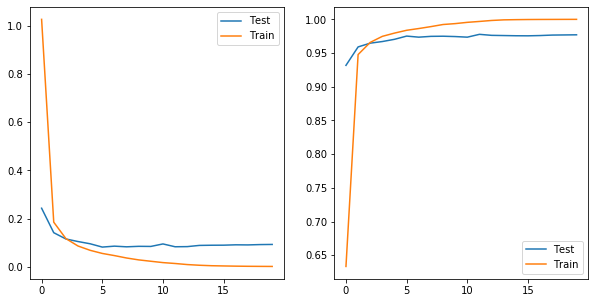

In [19]:
if not TEST_MODE:
    epochs_count = 20

    neural_network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    a,b,c,d = train_nn(neural_network, epochs_count, learning_rate)

In [0]:
assert max(d) > 0.972

### Проверка задания 3

In [0]:
# Проверка качества нейронной сети
if TEST_MODE:
    test_lib.train_task3(learning_rate, train_loader, test_loader)

### Задание 4
Обучите нейронную сеть как в задании 3, но используйте в качестве нелинейности ELU и ReLU. Качество должно быть не менее **0.977** в каждом случае (можно подбирать learning_rate, число эпох, коэффициенты в ELU/ReLU)

In [0]:
# Подбирайте параметры с помощью этих параметров
learning_rate_elu  = 0.01
learning_rate_relu = 0.1

epochs_elu = 30
epochs_relu = 30

a_elu = 1
a_relu = 0.1

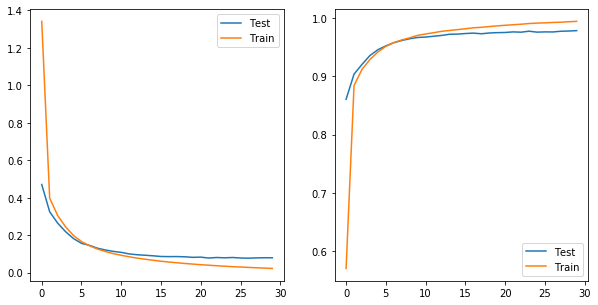

In [23]:
if not TEST_MODE:
    neural_network = layers.NeuralNetwork([layers.Linear(784, 100), layers.ELU(a_elu), layers.Linear(100, 100), 
                                           layers.ELU(a_elu), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    _,_,_,accuracy_elu = train_nn(neural_network, epochs_elu, learning_rate_elu)
    

In [0]:
assert max(accuracy_elu) > 0.977

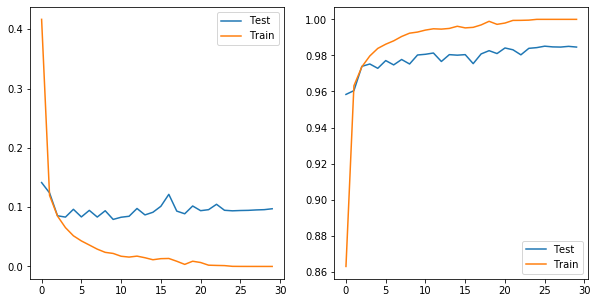

In [74]:
if not TEST_MODE:
    neural_network = layers.NeuralNetwork([layers.Linear(784, 100), layers.ReLU(a_relu), layers.Linear(100, 100), 
                                           layers.ReLU(a_relu), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    _,_,_,accuracy_relu = train_nn(neural_network, epochs_relu, learning_rate_relu)

In [0]:
assert max(accuracy_relu) > 0.977

### Проверка задания 4

In [0]:
# Проверка качества нейронной сети (ELU)
if TEST_MODE:
    test_lib.train_task4_elu(a_elu, learning_rate_elu, epochs_elu, train_loader, test_loader)

In [0]:
# Проверка качества нейронной сети (ReLU)
if TEST_MODE:
    test_lib.train_task4_relu(a_relu, learning_rate_relu, epochs_relu, train_loader, test_loader)

### Задание 5
Примените аугментацию:
* Небольшие вращения (-15, 15)
* Случайные сдвиги
* Шум

Какой прирост дают эти аугментации вместе и по отдельности? Напишите вывод. Постарайтесь добиться максимального качества, не изменяя размерности слоев

In [0]:
from scipy.ndimage.interpolation import shift, rotate

In [0]:
# X - np.array, X.shape = batch_size x 1 x 28 x 28
def add_noise(X, noise_std):
  result = np.copy(X)
  for i, img in enumerate(X):
    row, col, ch = img.shape
    gauss = np.random.normal(0,noise_std,(row,col,ch))
    gauss = gauss.reshape(row,col,ch)
    result[i] = img + torch.from_numpy(gauss)
  return result

def random_shift(X, max_shift):
  result = np.copy(X)
  for i, img in enumerate(X):
    result[i] = torch.from_numpy(shift(img, np.random.random()*max_shift, mode="nearest"))
  return result

def random_rotation(X, max_rot=15):
  result = np.copy(X)
  for i, img in enumerate(X):
    temp = rotate(img, np.random.random()*max_rot, mode="mirror", reshape=False)
    result[i] = torch.from_numpy(temp)
  return result

In [0]:
# Исправьте функцию train, чтобы она принимала augmentations - массив функций f(x),
# которые производят преобразования-аугментации
# Воспользуйтесь X.numpy(), а потом ndarray.view() для сокращения числа размеростей
def train_nn_aug(network, epochs, learning_rate, augmentations, train=train_loader, test=test_loader):
  train_loss_epochs = []
  test_loss_epochs = []
  train_accuracy_epochs = []
  test_accuracy_epochs = []
  for epoch in range(epochs):
    losses = []
    accuracies = []
    for X, y in train_loader:
      X_ = X.view(X.shape[0], -1).numpy()
      y = y.numpy()
      prediction = network.forward(X_)
      losses.append(network.get_loss(y))
      network.backward(y)
      network.step(learning_rate)
      accuracies.append((np.argmax(prediction, 1)==y).mean())
      for augmentation in augmentations:
        temp = augmentation(X)
        temp.resize(X.shape[0], X.shape[1]*X.shape[2]*X.shape[3])
        prediction = network.forward(temp)
        losses.append(network.get_loss(y))
        network.backward(y)
        network.step(learning_rate)
        accuracies.append((np.argmax(prediction, 1)==y).mean())
    train_loss_epochs.append(np.mean(losses))
    train_accuracy_epochs.append(np.mean(accuracies))
    losses = []
    accuracies = []    
    for X, y in test_loader:
      X = X.view(X.shape[0], -1).numpy()
      y = y.numpy()
      prediction = network.forward(X)
      losses.append(network.get_loss(y))
      accuracies.append((np.argmax(prediction, 1)==y).mean())
    test_loss_epochs.append(np.mean(losses))
    test_accuracy_epochs.append(np.mean(accuracies))
    clear_output(True)
    
    
    fig, axs = plt.subplots(1, 2, figsize=(10, 5))
    axs[0].plot(test_loss_epochs, label="Test")
    axs[0].plot(train_loss_epochs, label="Train")
    axs[1].plot(test_accuracy_epochs, label="Test")
    axs[1].plot(train_accuracy_epochs, label="Train")
    axs[0].legend()
    axs[1].legend()
    plt.show()
    print("TRAIN accuracy: {0}".format(max(train_accuracy_epochs)))
    print("TEST accuracy: {0}".format(max(test_accuracy_epochs)))
    
  return train_loss_epochs, test_loss_epochs, train_accuracy_epochs, test_accuracy_epochs

Шум

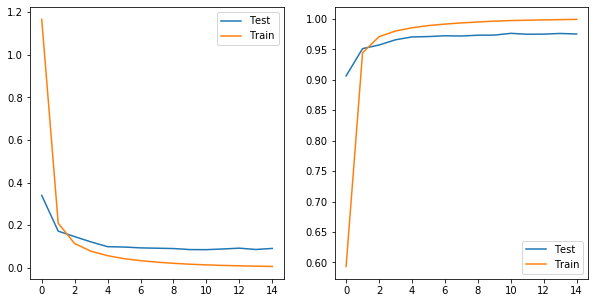

TRAIN accuracy: 0.9992083333333334
TEST accuracy: 0.9762380191693291


In [55]:
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
epochs = 15
learning_rate = 0.1
_,_,_,accuracy_test_noise = train_nn_aug(network, epochs, learning_rate, [lambda x: add_noise(x, 0.1)])

Вращение

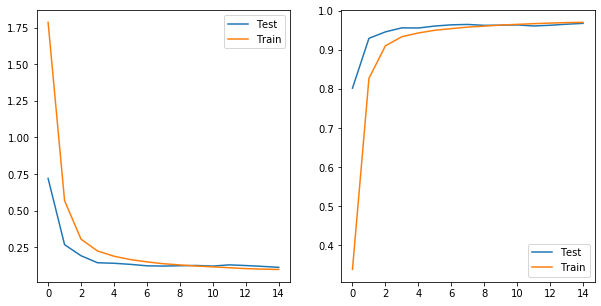

TRAIN accuracy: 0.9698083333333334
TEST accuracy: 0.9672523961661342


In [56]:
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
_,_,_,accuracy_test_rotate = train_nn_aug(network, epochs, learning_rate, [lambda x : random_rotation(x)])

Сдвиг

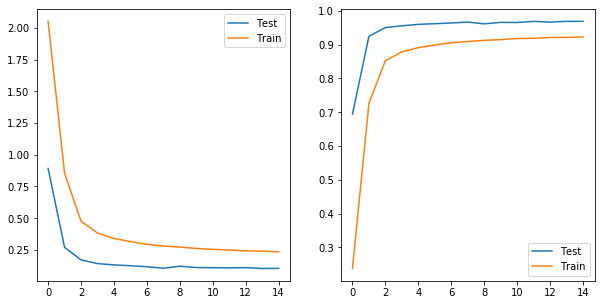

TRAIN accuracy: 0.9224
TEST accuracy: 0.9684504792332268


In [58]:
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
_,_,_,accuracy_test_shift = train_nn_aug(network, epochs, learning_rate, [lambda x: random_shift(x, 15)])

Все вместе

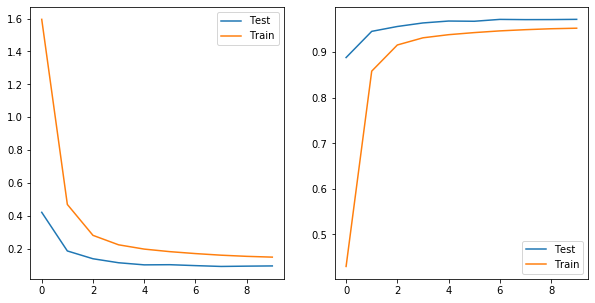

TRAIN accuracy: 0.9528041666666667
TEST accuracy: 0.9722444089456869


In [78]:
network = layers.NeuralNetwork([layers.Linear(784, 100), layers.Sigmoid(), layers.Linear(100, 100), 
                                           layers.Sigmoid(), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
_,_,_,accuracy_test_complex = train_nn_aug(network, 10, 0.05, [lambda x: add_noise(x, 0.1), lambda x: random_shift(x, 15), lambda x: random_rotation(x, 45)])

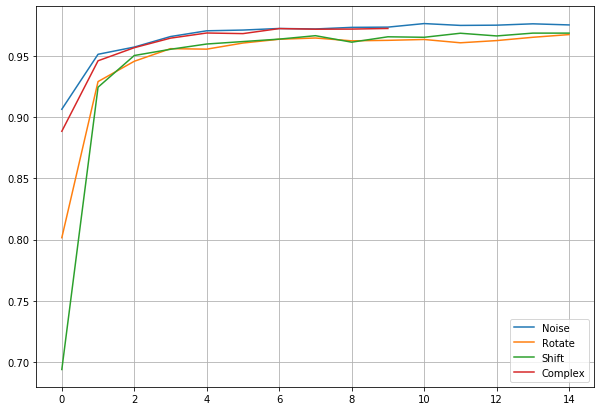

In [79]:
plt.figure(figsize=(10, 7))
plt.plot(accuracy_test_noise, label="Noise")
plt.plot(accuracy_test_rotate, label="Rotate")
plt.plot(accuracy_test_shift, label="Shift")
plt.plot(accuracy_test_complex, label="Complex")
plt.legend()
plt.grid()
plt.show()

In [0]:
# В этих функциях нужно создать нейронную сеть и массив функций-аугментаторов, которые дают наилучший скор
def create_best_nn():
    neural_network = layers.NeuralNetwork([layers.Linear(784, 100), layers.ELU(a_elu), layers.Linear(100, 100), 
                                           layers.ELU(a_elu), layers.Linear(100, 10), layers.SoftMax_NLLLoss()])
    return neural_network

def create_best_augmentations():
    augmentations =  [lambda x: add_noise(x, 0.1)]
    return augmentations

# Здесь же можно задать learning_rate и число эпох
learning_rate = 0.1
epochs_count = 20

### Проверка задания 5

In [0]:
# Проверка качества нейронной сети
if TEST_MODE:
    test_lib.train_task5(create_best_nn, create_best_augmentations, learning_rate, epochs_count,
                         train_loader, test_loader)

Спасибо за выполнение заданий!